In [50]:
import pandas as pd
import numpy as np
import collections
import math
import matplotlib.pyplot as plt

df = pd.read_csv("../data/finalScreen.tsv", sep="\t")
df = df[df["nUniq"] >= 2]
db = df[df["l2fc"] >= 2.3]
db = db[db["l2fcM"] >= 1]
db = db[db["ml10p"] > -np.log10(0.05)]
db = db[db["ml10adjP"] > -np.log10(2.5)]
db = db[db["rankRel"] < 500]

In [91]:
my_prots = ["DDB1", "CDK2", "CDK16", "SLC29A1"]
my_frags = ["C186", "C391", "C027"]

prot_counts = collections.defaultdict(int)
frag_counts = collections.defaultdict(int)

for r in db[["fragId", "geneName"]].values:
    prot_counts[r[1]] += 1
    frag_counts[r[0]] += 1

frag_counts_dict = frag_counts
prot_counts_dict= prot_counts

prot_counts = sorted(prot_counts.items(), key=lambda x: -x[1])
frag_counts = sorted(frag_counts.items(), key=lambda x: -x[1])

In [112]:
import networkx as nx
G = nx.Graph()
kept_prots = []
edges = []
cutoff = 10
for p in prot_counts:
    if p[1] >= cutoff:
        continue
    kept_prots += [p[0]]
    if p[0] in my_prots:
        s = 2
        entity = "Protein_Focus"
    else:
        s = 1
        entity = "Protein"
    G.add_node(p[0], label=p[0], counts=p[1], entity=entity, size=s)
for f in frag_counts:
    if f[0] in my_frags:
        s = 2
        entity = "Fragment_Focus"
    else:
        s = 1
        entity = "Fragment"
    G.add_node(f[0], label=f[0], counts=f[1], entity=entity, size=s)

for r in db[["fragId", "geneName", "l2fcM"]].values:
    if r[1] not in kept_prots:
        continue
    if r[0] in my_frags and r[1] in my_prots:
        focus = 2
        weight = 10
    else:
        focus = 1
        weight = 10
    G.add_edge(r[0], r[1], weight=r[2], enrichment=r[2], focus=focus)
    edges += [(r[0], r[1])]

connected_components = nx.connected_components(G)


# Sort the connected components by their size in descending order
sorted_components = sorted(connected_components, key=len, reverse=True)

# Get the largest connected component by selecting the first element of the sorted list
largest_component = sorted_components[0]

# Create a new subgraph of the original graph containing only the nodes in the largest component
G = G.subgraph(largest_component)

nx.write_gexf(G, "/Users/mduranfrigola/Desktop/ligand_discovery_graph_{0}.gexf".format(cutoff))

('C027', 'SLC29A1')
('C186', 'DDB1')
('C391', 'CDK16')
('C391', 'CDK2')


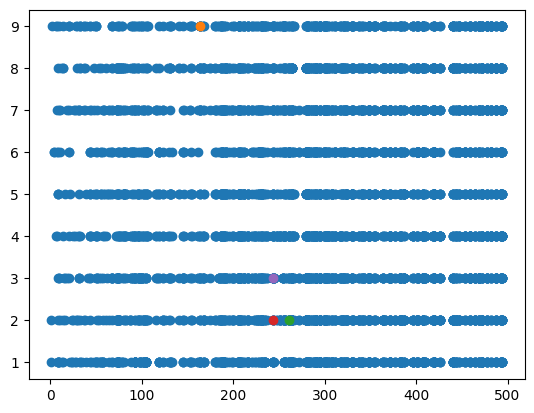

In [118]:
my_pairs = [("DDB1", "C186"), ("CDK2", "C391"), ("CDK16", "C391"), ("SLC29A1", "C027")]

x = []
y = []
for edge in edges:
    x += [frag_counts_dict[edge[0]]]
    y += [prot_counts_dict[edge[1]]]

plt.scatter(x, y)

for edge in edges:
    edge_ = edge[1], edge[0]
    if edge_ in my_pairs:
    
        print(edge)
        plt.scatter(x=[frag_counts_dict[edge[0]]], y=[prot_counts_dict[edge[1]]])


In [129]:
edge_betweenness = dict(nx.edge_betweenness_centrality(G))

('DDB1', 'C186') 0.000667025300602634
('CDK2', 'C391') 0.0013135069188212902
('CDK16', 'C391') 0.0006730071543293652
('SLC29A1', 'C027') 0.0010073198286331775


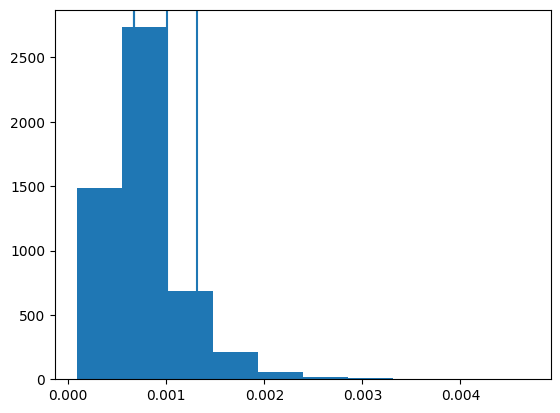

In [137]:
plt.hist([v for k,v in edge_betweenness.items()])
for p in my_pairs:
    print(p, edge_betweenness[p])
    plt.axvline(edge_betweenness[p])

(array([720., 364., 437., 273., 149.,  46.,  33.,  34.,  10.,   4.]),
 array([0.        , 0.22304489, 0.44608978, 0.66913468, 0.89217957,
        1.11522446, 1.33826935, 1.56131424, 1.78435914, 2.00740403,
        2.23044892]),
 <BarContainer object of 10 artists>)

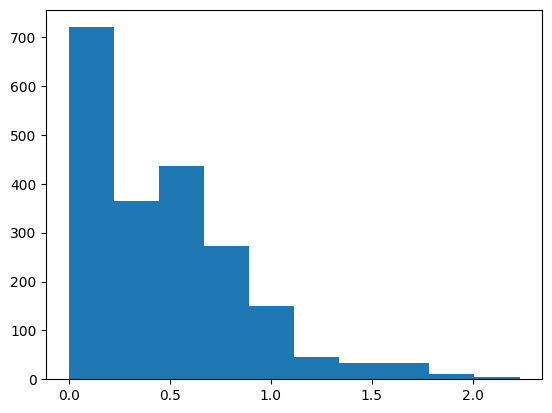

In [126]:
degrees = []
for k,v in dict(G.degree()).items():
    degrees += [np.log10(v)]
    

plt.hist(degrees)

In [65]:
prot_thetas = np.linspace(np.pi*0.5, np.pi*1.5, len(prot_counts))
prot_x = 1*np.cos(prot_thetas)
prot_y = 1*np.sin(prot_thetas)

frag_thetas = np.linspace(np.pi*0.5, np.pi*1.5, len(frag_counts))
frag_x = -1*np.cos(frag_thetas) + 0.5
frag_y = 1*np.sin(frag_thetas)

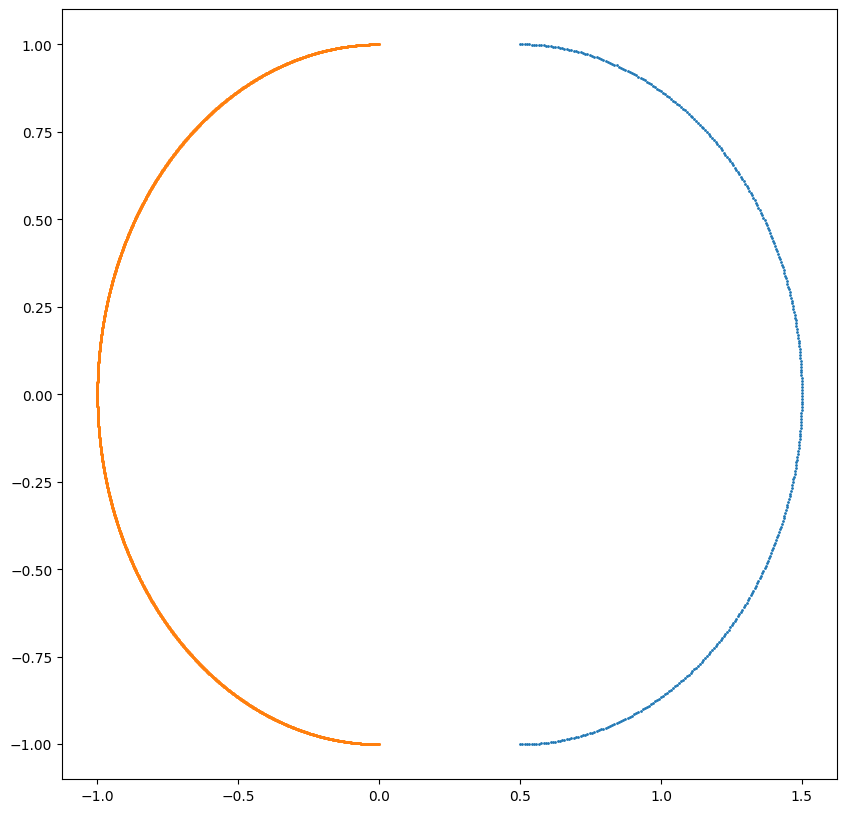

In [67]:
fig, ax = plt.subplots(1,1, figsize=(10,10))


ax.scatter(frag_x, frag_y, s=1)
ax.scatter(prot_x, prot_y, s=1)

In [38]:
import networkx as nx

# Create a graph
G = nx.Graph()

G.add_nodes_from(sorted(set(db["fragId"])), bipartite=0)
G.add_nodes_from(sorted(set(db["geneName"])), bipartite=1)

edges = []
for r in db[["fragId", "geneName"]].values:
    edges += [(r[0], r[1])]

G.add_edges_from(edges)

# Compute the connected components of the graph
connected_components = nx.connected_components(G)


# Sort the connected components by their size in descending order
sorted_components = sorted(connected_components, key=len, reverse=True)

# Get the largest connected component by selecting the first element of the sorted list
largest_component = sorted_components[0]

# Create a new subgraph of the original graph containing only the nodes in the largest component
G = G.subgraph(largest_component)


# Compute the positions of the nodes using the Fruchterman-Reingold algorithm



In [43]:
B = G
pos_a = nx.circular_layout([n for n in B if B.nodes[n]['bipartite'] == 0])
pos_b = nx.circular_layout([n for n in B if B.nodes[n]['bipartite'] == 1])
pos = dict()
pos.update({n: (r * 2, 0) for n, r in pos_a.items()})
pos.update({n: (r, 1) for n, r in pos_b.items()})

/Users/mduranfrigola/miniconda3/envs/bdfigs/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:425: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: setting an array element with a sequence.

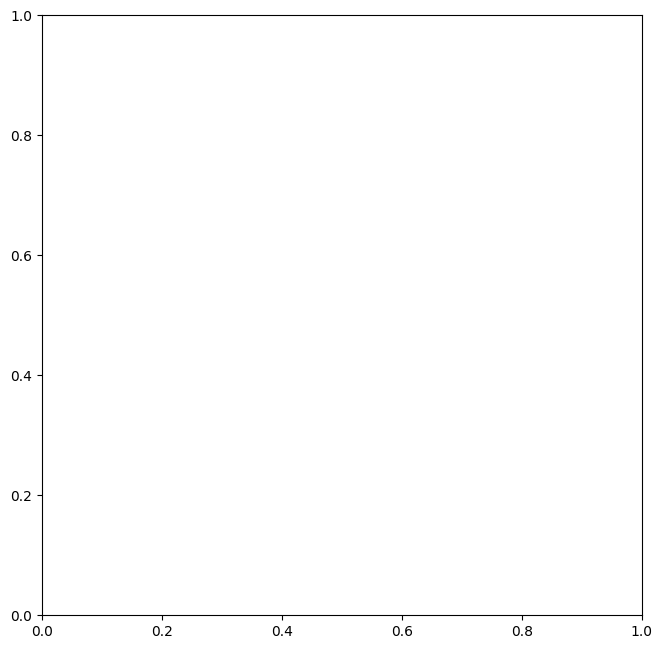

In [44]:
import matplotlib.pyplot as plt
#pos = nx.spring_layout(G, seed=42, k=0.01)
#pos = nx.bipartite_layout(G, nodes=sorted(set(db["fragId"])))
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=False, node_size=10, node_color="skyblue", font_size=14)

In [40]:
help(nx.bipartite_layout)

Help on function bipartite_layout in module networkx.drawing.layout:

bipartite_layout(G, nodes, align='vertical', scale=1, center=None, aspect_ratio=1.3333333333333333)
    Position nodes in two straight lines.
    
    Parameters
    ----------
    G : NetworkX graph or list of nodes
        A position will be assigned to every node in G.
    
    nodes : list or container
        Nodes in one node set of the bipartite graph.
        This set will be placed on left or top.
    
    align : string (default='vertical')
        The alignment of nodes. Vertical or horizontal.
    
    scale : number (default: 1)
        Scale factor for positions.
    
    center : array-like or None
        Coordinate pair around which to center the layout.
    
    aspect_ratio : number (default=4/3):
        The ratio of the width to the height of the layout.
    
    Returns
    -------
    pos : dict
        A dictionary of positions keyed by node.
    
    Examples
    --------
    >>> G = nx.bipar